In [1]:
#import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
import pathlib

import urllib.request


In [3]:
print(tf.__version__)

2.6.0


In [4]:
if not os.path.exists('./data'):
    data_url = os.getenv('DAT_URL')
    save_path = 'data.zip'
    if data_url:
        urllib.request.urlretrieve(data_url, save_path)
        !unzip ./data.zip
    else:
        raise Exception('URL to download data not found in environment')

In [5]:
data_dir = './data'

In [6]:
used_device = tf.config.list_physical_devices()
print(used_device)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:6', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:7', device_type='GPU')]


2021-11-03 03:22:12.089594: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-03 03:22:12.091292: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-03 03:22:12.092897: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-03 03:22:12.094522: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-03 03:22:12.096129: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [7]:
mirrored_strategy = tf.distribute.MirroredStrategy()

2021-11-03 03:22:13.231345: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-03 03:22:13.232885: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-03 03:22:13.234392: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-03 03:22:13.235933: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-03 03:22:13.237446: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')


In [8]:
n_gpu = mirrored_strategy.num_replicas_in_sync
print(n_gpu)

8


In [9]:
ACCURACY_THRESHOLD = 0.98
# Implement callback function to stop training
# when accuracy reaches e.g. ACCURACY_THRESHOLD = 0.95class myCallback(tf.keras.callbacks.Callback): 
class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('val_accuracy') > ACCURACY_THRESHOLD):   
            print("\nReached %2.2f%% validation accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))   
            self.model.stop_training = True
callbacks = myCallback()

# ==== Vanilla CNN Model ====

In [14]:
epochs = 50
batch_size = 64*n_gpu
img_height = 128
img_width = 128

from_dir_kwargs = dict(
		directory = data_dir,
		  validation_split=0.2,
		  seed=123,
		  image_size=(img_height, img_width),
		  batch_size=batch_size)

train_ds = \
	tf.keras.utils.image_dataset_from_directory(
	  subset="training", **from_dir_kwargs)

val_ds = \
    tf.keras.utils.image_dataset_from_directory(
      subset="validation", **from_dir_kwargs)

class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

Found 22676 files belonging to 7 classes.
Using 18141 files for training.
Found 22676 files belonging to 7 classes.
Using 4535 files for validation.
['bags', 'belts', 'boot', 'jacket', 'sandals', 'shoes', 'wallets']
(512, 128, 128, 3)
(512,)


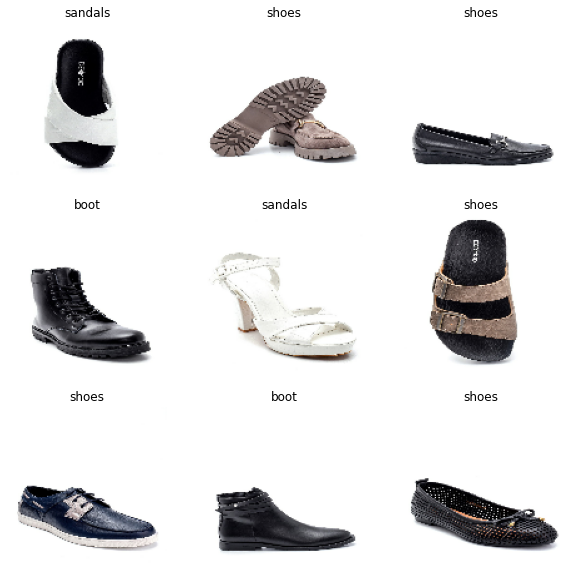

In [15]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [16]:
with mirrored_strategy.scope():
    model = Sequential([
      layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
        layers.Dropout(0.2),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(num_classes)
    ])
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [17]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
callbacks = [callbacks]
)

2021-11-03 03:22:50.465359: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}



Epoch 1/50
INFO:tensorflow:batch_all_reduce: 10 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 10 all-reduces with algorithm = nccl, num_packs = 1


2021-11-03 03:23:02.505562: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101
2021-11-03 03:23:02.997869: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101
2021-11-03 03:23:03.381460: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101
2021-11-03 03:23:03.861527: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101
2021-11-03 03:23:04.368819: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101
2021-11-03 03:23:05.023230: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101
2021-11-03 03:23:05.531164: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101
2021-11-03 03:23:05.817967: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101


36/36 [==============================] - ETA: 0s - loss: 1.3654 - accuracy: 0.4889

2021-11-03 03:23:17.915856: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}



36/36 [==============================] - 34s 412ms/step - loss: 1.3654 - accuracy: 0.4889 - val_loss: 0.8147 - val_accuracy: 0.7118
Epoch 2/50
36/36 [==============================] - 12s 288ms/step - loss: 0.6250 - accuracy: 0.7728 - val_loss: 0.5155 - val_accuracy: 0.8201
Epoch 3/50
36/36 [==============================] - 12s 288ms/step - loss: 0.4170 - accuracy: 0.8557 - val_loss: 0.4229 - val_accuracy: 0.8514
Epoch 4/50
36/36 [==============================] - 12s 287ms/step - loss: 0.3355 - accuracy: 0.8826 - val_loss: 0.3303 - val_accuracy: 0.8897
Epoch 5/50
36/36 [==============================] - 12s 288ms/step - loss: 0.2769 - accuracy: 0.9018 - val_loss: 0.2894 - val_accuracy: 0.9001
Epoch 6/50
36/36 [==============================] - 12s 289ms/step - loss: 0.2258 - accuracy: 0.9210 - val_loss: 0.2601 - val_accuracy: 0.9098
Epoch 7/50
36/36 [==============================] - 12s 295ms/step - loss: 0.1907 - accuracy: 0.9316 - val_loss: 0.2544 - val_accuracy: 0.9142
Epoch 8/50

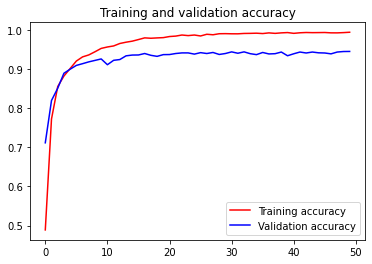

<Figure size 432x288 with 0 Axes>

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(range(len(acc)), acc, 'r', label='Training accuracy')
plt.plot(range(len(acc)), val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

## ==== Retest with data augmentation ====

In [19]:
keras.backend.clear_session()

In [20]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
            input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)


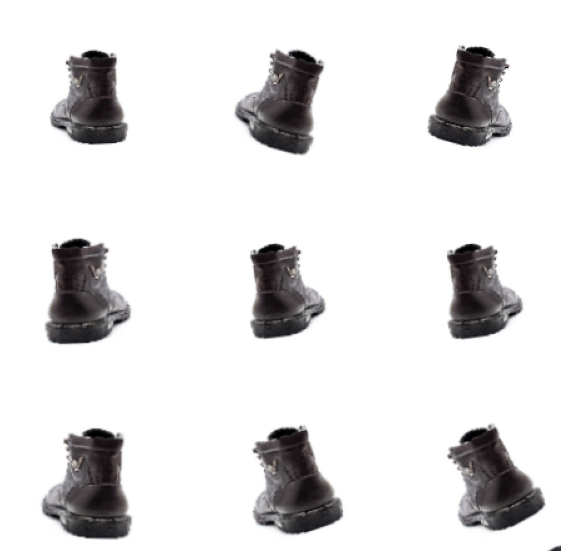

In [21]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [22]:
with mirrored_strategy.scope():
    model = Sequential([
      data_augmentation,
      layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
        layers.Dropout(0.2),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(num_classes)
    ])

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 128, 128, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)       

In [23]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
callbacks = [callbacks]
)

2021-11-03 03:33:59.344423: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}



Epoch 1/50
INFO:tensorflow:batch_all_reduce: 10 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 10 all-reduces with algorithm = nccl, num_packs = 1
35/36 [============================>.] - ETA: 0s - loss: 1.3472 - accuracy: 0.4716

2021-11-03 03:34:21.321509: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}



36/36 [==============================] - 27s 358ms/step - loss: 1.3445 - accuracy: 0.4732 - val_loss: 1.0484 - val_accuracy: 0.6295
Epoch 2/50
36/36 [==============================] - 12s 290ms/step - loss: 0.9328 - accuracy: 0.6500 - val_loss: 0.7897 - val_accuracy: 0.7067
Epoch 3/50
36/36 [==============================] - 12s 288ms/step - loss: 0.7595 - accuracy: 0.7198 - val_loss: 0.6820 - val_accuracy: 0.7563
Epoch 4/50
36/36 [==============================] - 12s 294ms/step - loss: 0.6609 - accuracy: 0.7588 - val_loss: 0.6985 - val_accuracy: 0.7385
Epoch 5/50
36/36 [==============================] - 12s 293ms/step - loss: 0.5793 - accuracy: 0.7865 - val_loss: 0.5972 - val_accuracy: 0.7896
Epoch 6/50
36/36 [==============================] - 12s 289ms/step - loss: 0.5262 - accuracy: 0.8101 - val_loss: 0.4958 - val_accuracy: 0.8238
Epoch 7/50
36/36 [==============================] - 12s 288ms/step - loss: 0.4764 - accuracy: 0.8295 - val_loss: 0.4682 - val_accuracy: 0.8384
Epoch 8/50

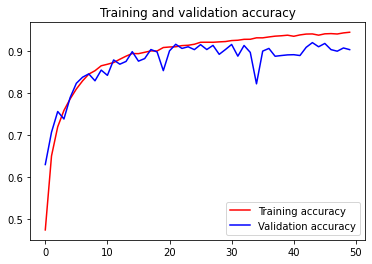

<Figure size 432x288 with 0 Axes>

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(range(len(acc)), acc, 'r', label='Training accuracy')
plt.plot(range(len(acc)), val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

## ==== Transfer Learning ====

In [25]:
keras.backend.clear_session()

In [26]:
with mirrored_strategy.scope():
    vgg16 = keras.applications.vgg16
    conv_model = vgg16.VGG16(weights='imagenet', 
                                include_top=False,
                            input_shape=(img_height, img_width,3))
    i = tf.keras.layers.Input([None, None, 3], dtype = tf.uint8)
    x = tf.cast(i, tf.float32)
    x = tf.keras.applications.vgg16.preprocess_input(x)
    core = conv_model
    x = core(x)
    model = tf.keras.Model(inputs=[i], outputs=[x])

    # Add Dropout layer to reduce over-fitting
    x = layers.Dropout(0.2)(model.output)
    # flatten the output of the convolutional part: 
    x = keras.layers.Flatten()(x)
    # three hidden layers
    x = keras.layers.Dense(100, activation='relu')(x)
    x = keras.layers.Dense(100, activation='relu')(x)
    x = keras.layers.Dense(100, activation='relu')(x)
    # final softmax layer with two categories (dog and cat)
    predictions = keras.layers.Dense(num_classes, activation='softmax')(x)

    # creating the full model:
    full_model = keras.models.Model(inputs=model.input, outputs=predictions)

    for layer in model.layers:
        layer.trainable = False

    full_model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  #loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy'])

58900480/58889256 [==============================] - 1s 0us/step


In [27]:
full_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
tf.cast (TFOpLambda)         (None, None, None, 3)     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, None, None, 3)     0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, None, None, 3)     0         
_________________________________________________________________
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0   

In [28]:
history = full_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
callbacks = [callbacks]
)

2021-11-03 03:44:57.097583: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}



Epoch 1/50
INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = nccl, num_packs = 1
36/36 [==============================] - ETA: 0s - loss: 1.4183 - accuracy: 0.7920

2021-11-03 03:46:34.812158: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}



36/36 [==============================] - 151s 3s/step - loss: 1.4183 - accuracy: 0.7920 - val_loss: 0.3007 - val_accuracy: 0.9186
Epoch 2/50
36/36 [==============================] - 17s 407ms/step - loss: 0.1995 - accuracy: 0.9378 - val_loss: 0.2144 - val_accuracy: 0.9367
Epoch 3/50
36/36 [==============================] - 16s 391ms/step - loss: 0.1220 - accuracy: 0.9576 - val_loss: 0.1770 - val_accuracy: 0.9453
Epoch 4/50
36/36 [==============================] - 16s 398ms/step - loss: 0.0869 - accuracy: 0.9694 - val_loss: 0.1619 - val_accuracy: 0.9504
Epoch 5/50
36/36 [==============================] - 16s 394ms/step - loss: 0.0697 - accuracy: 0.9756 - val_loss: 0.1639 - val_accuracy: 0.9499
Epoch 6/50
36/36 [==============================] - 16s 404ms/step - loss: 0.0604 - accuracy: 0.9786 - val_loss: 0.1661 - val_accuracy: 0.9519
Epoch 7/50
36/36 [==============================] - 16s 396ms/step - loss: 0.0568 - accuracy: 0.9806 - val_loss: 0.1854 - val_accuracy: 0.9521
Epoch 8/50
3

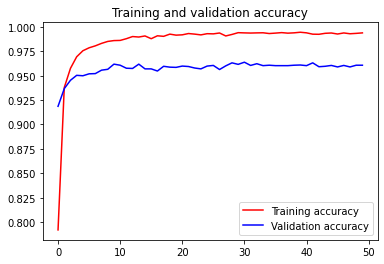

<Figure size 432x288 with 0 Axes>

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(range(len(acc)), acc, 'r', label='Training accuracy')
plt.plot(range(len(acc)), val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()